In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from evaluation.metrics import extremal_coefficient
import cmcrameri 
import scipy as sc

Visualization of energy scores

In [2]:
def get_energy_score_single(y_true: float, y_pred: float, sd: bool = False) -> float:
    """Compute mean energy score from samples of the predictive distribution.

    Args:
        y_true (float): True values.
        y_pred (float): Samples from predictive distribution.
        sd (bool, optional): _description_. Defaults to False.

    Returns:
        float: energy scores
    """

    N = y_true.shape[0]
    M = y_pred.shape[2]

    es_12 = np.zeros(y_true.shape[0])
    es_22 = np.zeros(y_true.shape[0])

    for i in range(N):
        es_12[i] = np.sum(
            np.sqrt(np.sum(np.square((y_true[[i], :].T - y_pred[i, :, :])), axis=0))
        )
        es_22[i] = np.sum(
            np.sqrt(
                np.sum(
                    np.square(
                        np.expand_dims(y_pred[i, :, :], axis=2)
                        - np.expand_dims(y_pred[i, :, :], axis=1)
                    ),
                    axis=0,
                )
            )
        )

    scores = es_12 / M - 0.5 * 1 / (M * M) * es_22
    return scores


def get_functional_energy_score_single(
    model: str,
    dh: float = 0.1,
    true_parameters: float = None,
    estimate_parameters: float = None,
    estimate_function: np.array = None,
    method: str = "sample",
    max_length: float = 42.5,
    sd: bool = False,
    model2: str = None,
) -> float:
    """Compute mean energy score from support points of the extremal coefficient function.

    Args:
        modle (str): Model
        dh (float, optional): Step for distance h. Defaults to 0.1.
        true_parameters (float, optional): Array with the two parameters r,s of the true model. Defaults to None.
        estimate_parameters (float, optional): Array with the parameters r,s of the estimated model. Defaults to None.
        estimate_function (np.array, optional): Estimated extremal coefficient function. Defaults to None.
        method (str, optional): Whether to calculate the error based on multiple samples or direct estimation. Defaults to "sample".
        max_length (float, optional): Used to compute the upper bound of integration. Defaults to 42.5.
        alpha (float, optional): Alpha value of quantile in (0,1). Defaults to 0.05.
        sd (bool, optional): Whether to return the standard deviation. Defaults to False.
        model2 (str, optional): String describing the estimated model. Defaults to None.
    Returns:
        float: energy scores
    """

    model2 = model if model2 == None else model2    
    h_support = np.arange(dh, max_length + dh, dh)
    # Calculate true extremal coefficient functions
    true_theta = extremal_coefficient(h_support, model, true_parameters[:, 0], true_parameters[:, 1])
    if method == "direct":
        es = get_energy_score_single(y_true = true_theta, y_pred = estimate_function, sd = True)
    else:
        theta_aggregated = extremal_coefficient(h_support, model2, estimate_parameters[:,0:1], estimate_parameters[:,1:2])
        es = get_energy_score_single(y_true = true_theta, y_pred = theta_aggregated, sd = True)

    return es

In [3]:
dir = "normal"
model = "brown"
model2 = None
alpha =0.05

In [4]:
# get data
pred_param_es = np.load(f"../data/{dir}/results/{model}_cnn_es.npy")
true_param = np.load(f"../data/{dir}/data/{model}_test_params.npy")
pred_ext_coef = np.load(f"../data/{dir}/results/{model}_cnn_es_theta.npy")
energy_scores_cnn_es_theta = get_functional_energy_score_single(model = model, true_parameters = true_param, estimate_function = pred_ext_coef, sd = False, method = "direct")
energy_scores_cnn_es = get_functional_energy_score_single(model = model, true_parameters = true_param, estimate_parameters = pred_param_es, sd = False, model2=model2)

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
plt.rcParams['image.cmap'] = cmap_name

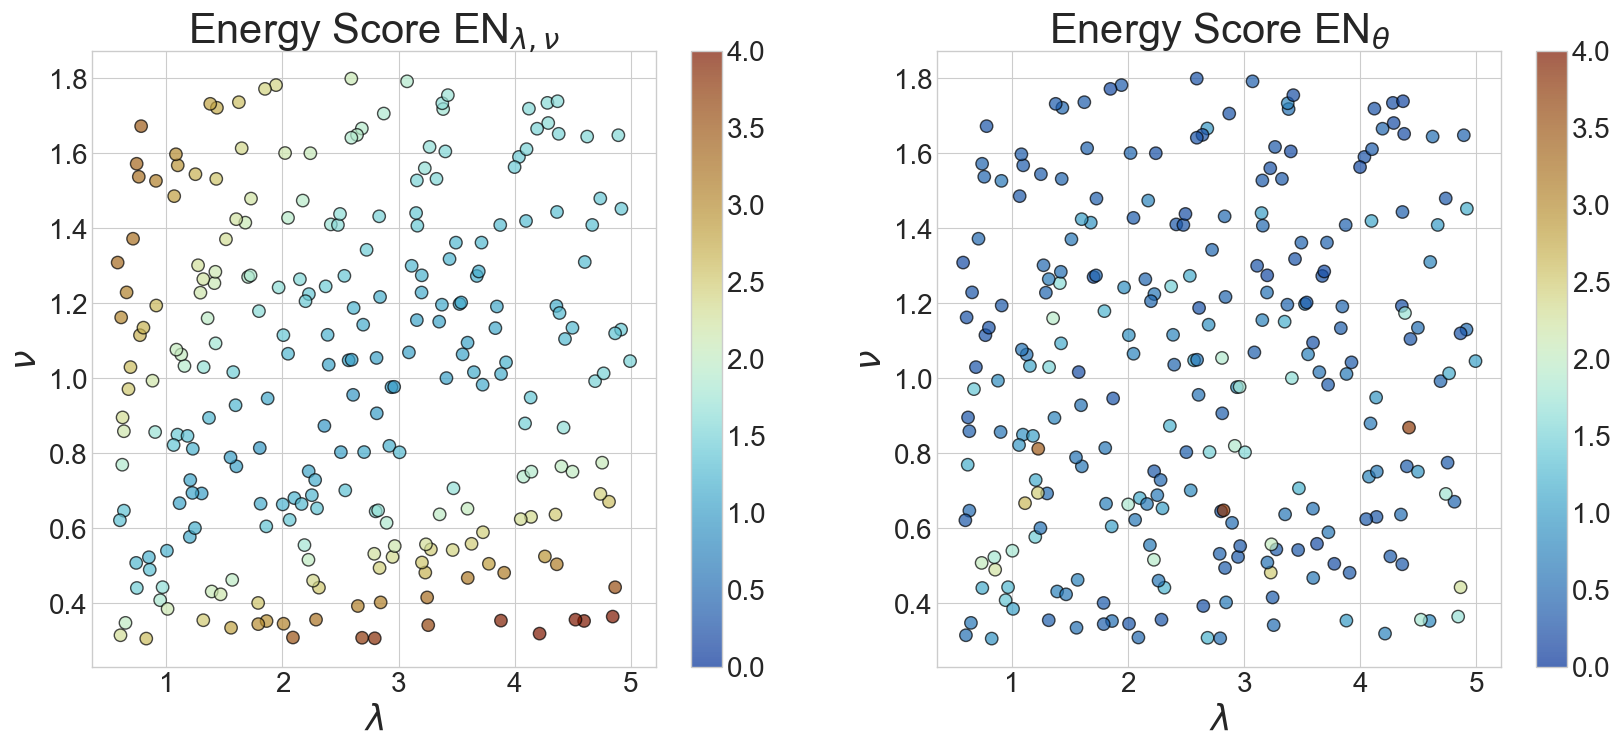

In [9]:
ticksize = 20
fontsize = 28
axsize = 25
legendsize = 20
titlesize = 30
lw = 3.5


sores_theta = energy_scores_cnn_es_theta[:250]
scores_param = energy_scores_cnn_es[:250]
params = true_param[:250,:]

fig, axs = plt.subplots(1,2, figsize = (20,8))

cs = axs[0].scatter(params[:,0], params[:,1], c=scores_param, cmap=cmap, vmin=0, vmax=4, alpha = 0.7, s = 80, edgecolors = "black")
cbar = fig.colorbar(cs)
axs[0].set_title('Energy Score EN' r"$_{\lambda,\nu}$", fontsize = titlesize)
axs[0].set_xlabel(r'$\lambda$', fontsize = axsize)
axs[0].set_ylabel(r'$\nu$', fontsize = axsize)
axs[0].tick_params(axis='both', labelsize=ticksize)
cbar.ax.tick_params(labelsize=ticksize)

cs_1 = axs[1].scatter(params[:,0], params[:,1], c=sores_theta, cmap=cmap, vmin=0, vmax=4, alpha = 0.7, s = 80, edgecolors = "black")
cbar = fig.colorbar(cs_1)
axs[1].set_title('Energy Score EN' r'$_\theta$', fontsize = titlesize)
axs[1].set_xlabel(r'$\lambda$', fontsize = axsize)
axs[1].set_ylabel(r'$\nu$', fontsize = axsize)
axs[1].tick_params(axis='both', labelsize=ticksize)
cbar.ax.tick_params(labelsize=ticksize)

plt.show()

Visualization extremal coefficient function

In [12]:
def extremal_coefficient_1(r, s, h, model):
    if(model == "brown"):
        res = 2 * sc.special.ndtr(np.sqrt(np.power((h / r), s)) / 2)
    elif(model == "powexp"): 
        res = 1 + np.sqrt((1 - np.exp(-np.power((h / r), s))) / 2)
    elif(model == "whitmat"):
        res = 1 + np.sqrt(
            (1-np.power(2, (1 - s))/sc.special.gamma(s)* np.power((h / r), s)* sc.special.kv(s, (h / r)))/2)
    return res

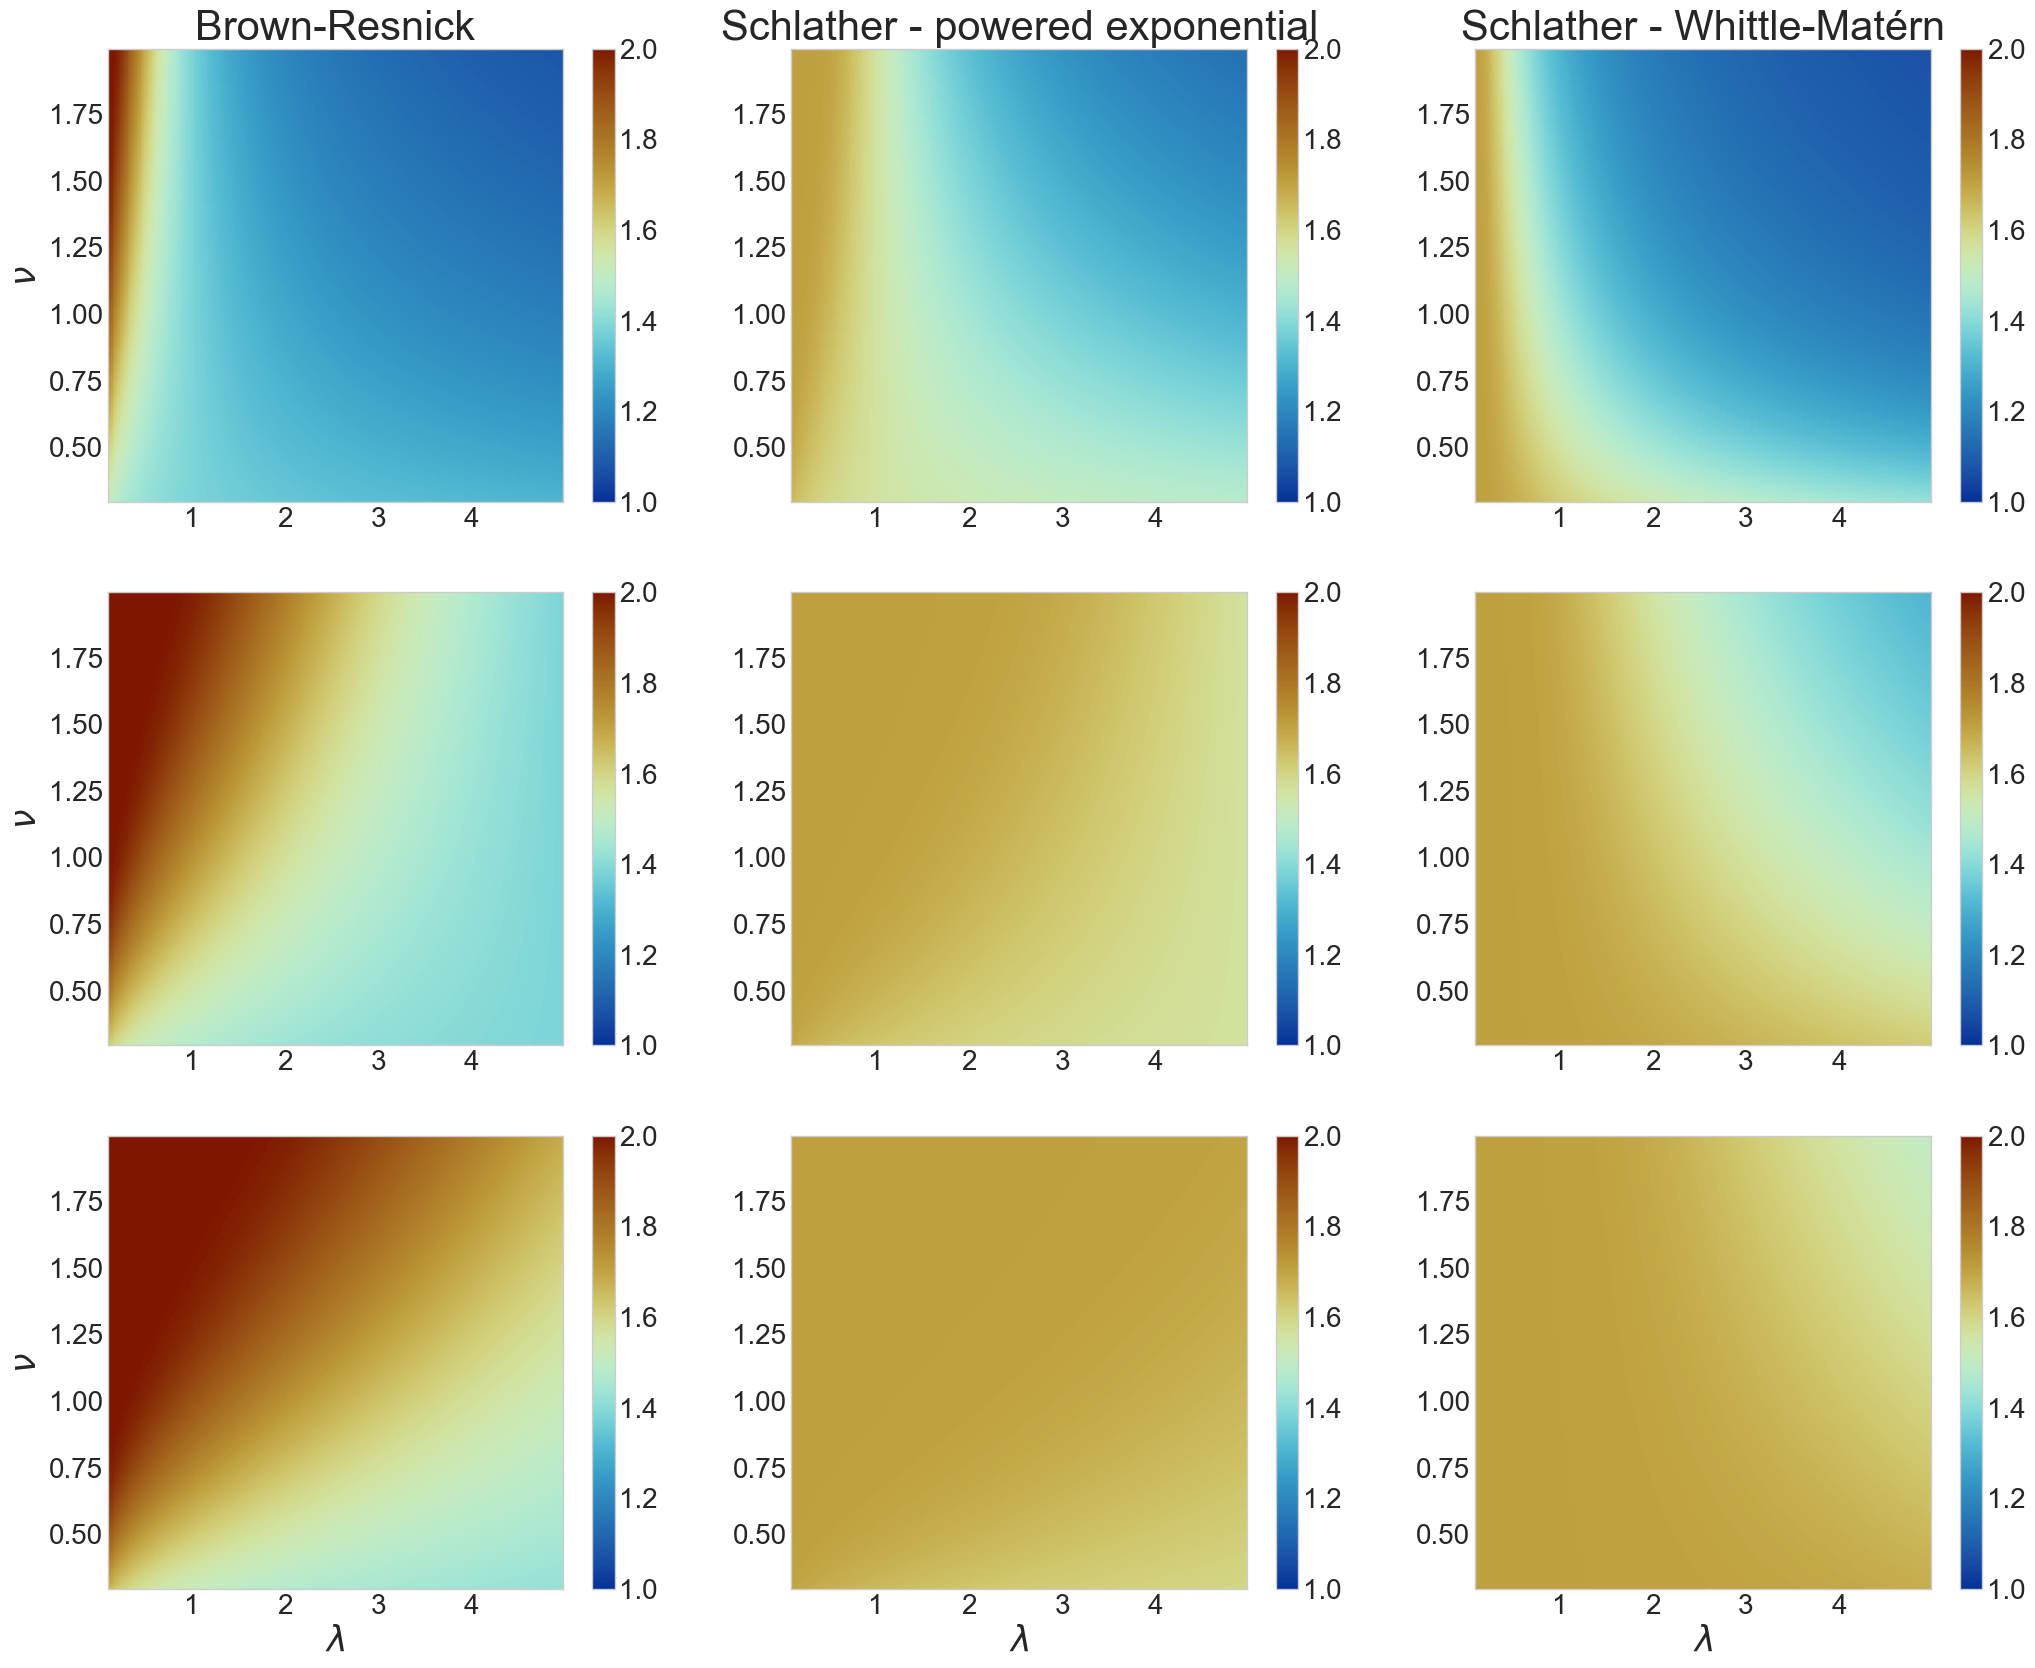

In [13]:
lambdas = np.arange(0.1,5,0.02)
nus = np.arange(0.3,2,0.01)
hs = [1,5,10]
extremals = np.zeros((len(nus),len(lambdas)))
extremals_pow = np.zeros((len(nus),len(lambdas)))
extremals_whitmat = np.zeros((len(nus),len(lambdas)))
for i in range(len(lambdas)):
    for j in range(len(nus)):
        extremals[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[0], "brown")
        extremals_pow[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[0], "powexp")
        extremals_whitmat[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[0], "whitmat")

extremals_1 = np.zeros((len(nus),len(lambdas)))
extremals_pow_1 = np.zeros((len(nus),len(lambdas)))
extremals_whitmat_1 = np.zeros((len(nus),len(lambdas)))
for i in range(len(lambdas)):
    for j in range(len(nus)):
        extremals_1[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[1], "brown")
        extremals_pow_1[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[1], "powexp")
        extremals_whitmat_1[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[1], "whitmat")

extremals_2 = np.zeros((len(nus),len(lambdas)))
extremals_pow_2 = np.zeros((len(nus),len(lambdas)))
extremals_whitmat_2 = np.zeros((len(nus),len(lambdas)))
for i in range(len(lambdas)):
    for j in range(len(nus)):
        extremals_2[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[2], "brown")
        extremals_pow_2[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[2], "powexp")
        extremals_whitmat_2[j,i] = extremal_coefficient_1(lambdas[i], nus[j], hs[2], "whitmat")

extremals_frame = pd.DataFrame(extremals, columns=lambdas, index = nus)
extremals_frame_pow = pd.DataFrame(extremals_pow, columns=lambdas, index = nus)
extremals_frame_whitmat = pd.DataFrame(extremals_whitmat, columns=lambdas, index = nus)

extremals_frame_1 = pd.DataFrame(extremals_1, columns=lambdas, index = nus)
extremals_frame_pow_1 = pd.DataFrame(extremals_pow_1, columns=lambdas, index = nus)
extremals_frame_whitmat_1 = pd.DataFrame(extremals_whitmat_1, columns=lambdas, index = nus)

extremals_frame_2 = pd.DataFrame(extremals_2, columns=lambdas, index = nus)
extremals_frame_pow_2 = pd.DataFrame(extremals_pow_2, columns=lambdas, index = nus)
extremals_frame_whitmat_2 = pd.DataFrame(extremals_whitmat_2, columns=lambdas, index = nus)



fig, ax = plt.subplots(3, 3, figsize = (25,20))
cs_00=ax[0,0].pcolor(lambdas,nus,  extremals_frame, vmin=1, vmax=2)
ax[0,0].set_ylabel(r'$\nu$', fontsize = axsize)
ax[0,0].set_title('Brown-Resnick', fontsize = titlesize)
ax[0,0].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_00)
cbar.ax.tick_params(labelsize=ticksize)

cs_01=ax[0,1].pcolor( lambdas, nus,extremals_frame_pow, vmin=1, vmax=2)

ax[0,1].set_title('Schlather - powered exponential', fontsize = titlesize)
ax[0,1].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_01)
cbar.ax.tick_params(labelsize=ticksize)

cs_02=ax[0,2].pcolor(lambdas, nus,extremals_frame_whitmat, vmin=1, vmax=2)
ax[0,2].set_title('Schlather - Whittle-Matérn', fontsize = titlesize)
ax[0,2].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_02)
cbar.ax.tick_params(labelsize=ticksize)


cs_10=ax[1,0].pcolor(lambdas,nus,  extremals_frame_1, vmin=1, vmax=2)
ax[1,0].set_ylabel(r'$\nu$', fontsize = axsize)
ax[1,0].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_10)
cbar.ax.tick_params(labelsize=ticksize)

cs_11=ax[1,1].pcolor( lambdas, nus,extremals_frame_pow_1, vmin=1, vmax=2)
ax[1,1].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_11)
cbar.ax.tick_params(labelsize=ticksize)

cs_12=ax[1,2].pcolor(lambdas, nus,extremals_frame_whitmat_1, vmin=1, vmax=2)
ax[1,2].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_12)
cbar.ax.tick_params(labelsize=ticksize)


cs_20=ax[2,0].pcolor(lambdas,nus,  extremals_frame_2, vmin=1, vmax=2)
ax[2,0].set_xlabel(r'$\lambda$', fontsize = axsize)
ax[2,0].set_ylabel(r'$\nu$', fontsize = axsize)
ax[2,0].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_20)
cbar.ax.tick_params(labelsize=ticksize)

cs_21=ax[2,1].pcolor( lambdas, nus,extremals_frame_pow_2, vmin=1, vmax=2)
ax[2,1].set_xlabel(r'$\lambda$', fontsize = axsize)
ax[2,1].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_21)
cbar.ax.tick_params(labelsize=ticksize)

cs_22=ax[2,2].pcolor(lambdas, nus,extremals_frame_whitmat_2, vmin=1, vmax=2)
ax[2,2].set_xlabel(r'$\lambda$', fontsize = axsize)
ax[2,2].tick_params(axis='both', labelsize=ticksize)
cbar = fig.colorbar(cs_22)
cbar.ax.tick_params(labelsize=ticksize)


plt.show()